# El mecanismo de Attention

## Introducción
Attention es un mecanismo complejo de abordar al principio. Hay mucha data dando vueltas que, lamentablemente no clarifica nada si no al contrario. A no preocuparse si los conceptos tardan en decantar y a no desesperarse. La mejor fuente para entender el mecanismo de manera visual es la lista de Neural Networks del canal de Youtube 3Blue1Brown (three blue, one brown), en particular los videos 5, 6 y 7, que tratan de modelos de lenguajes, Attention y Transformers, son de particular valor para el contenido de este curso. Si bien los videos están en inglés, la traducción automática es semi-descente.

### Donde estamos parados y hacia donde vamos?

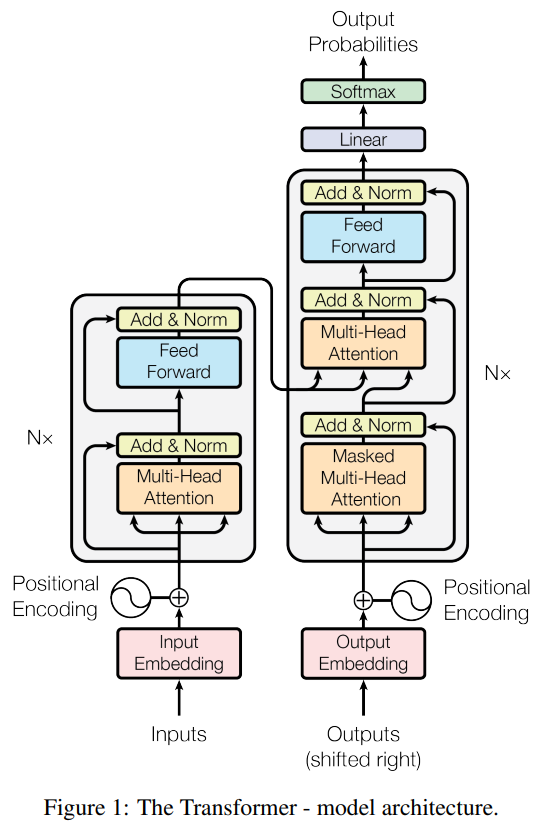

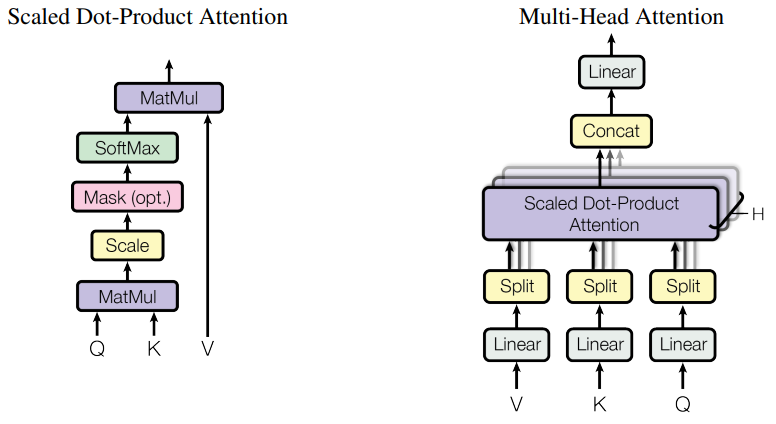

Vamos a tratar de abordar Attention con el mismo enfoque que Andrej Karpathy en sus videos, es decir, como un mecanismo de transmisión de información a través del modelo. La información se transmite desde los embeddings del contexto de un token al embedding que lo representa.

[LLM Visualization](https://bbycroft.net/llm)


### Que esperamos del mecanismo de Attention?
En el modelo de transformers, los embeddings de los tokens deben modificarse para asimilar información de su contexto. Por ejemplo:
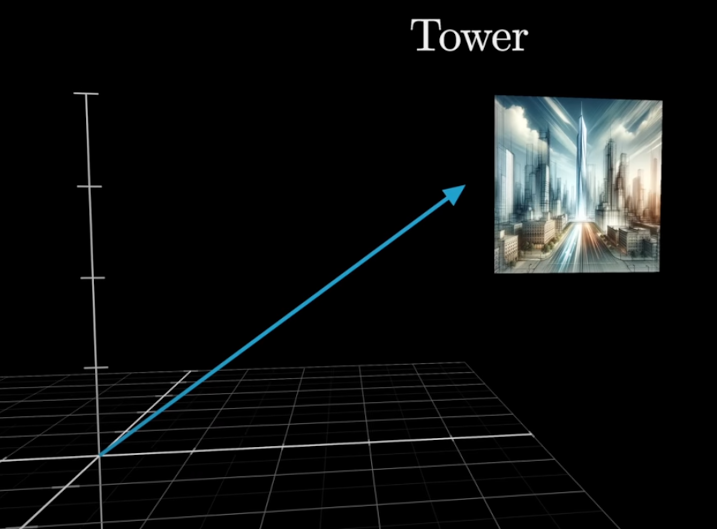

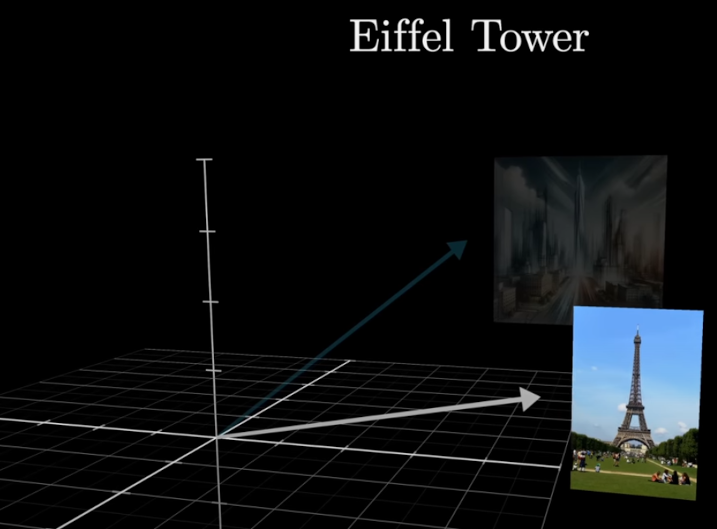

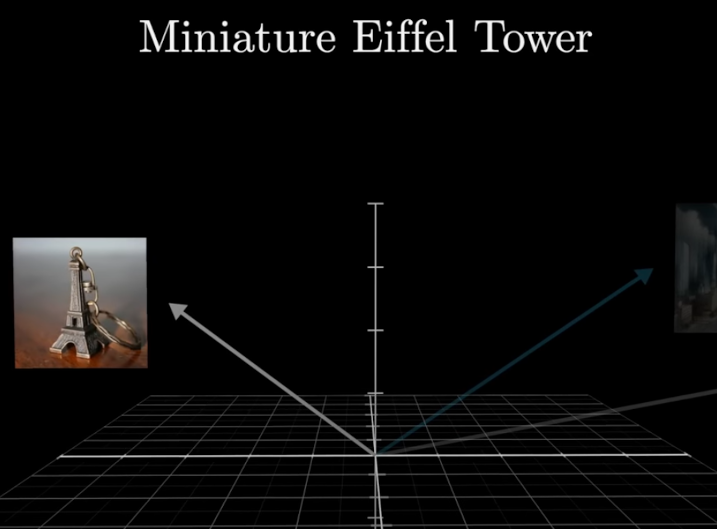

¿Qué información se transmite? Depende. Depende del contexto en el cual el token está inmerso, depende de los datos de entrenamiento, depende de lo que el modelo aprendió de esos datos.

1) El embedding de un token es determinístico. Una vez que el modelo está entrenado, es siempre el mismo.
2) El transformer (decoder) actualiza el embedding de todos los tokens del contexto, usando información de todos los tokens del contexto anterior, para predecir el siguiente token
3) La probabilidad del token siguiente al último del contexto, depende exclusivamente del embedding (modificado, después de "fluir" a través del modelo) del último token del contexto.

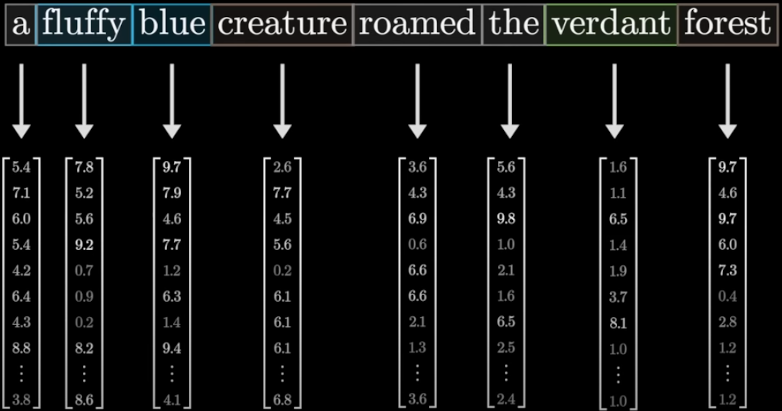

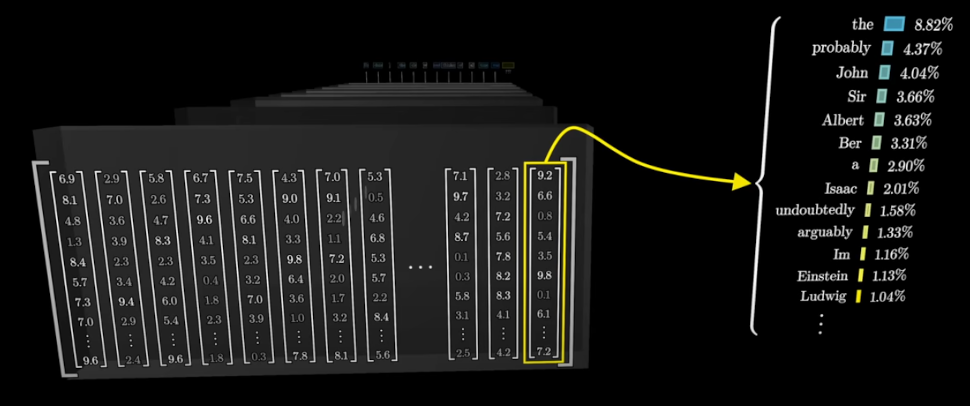

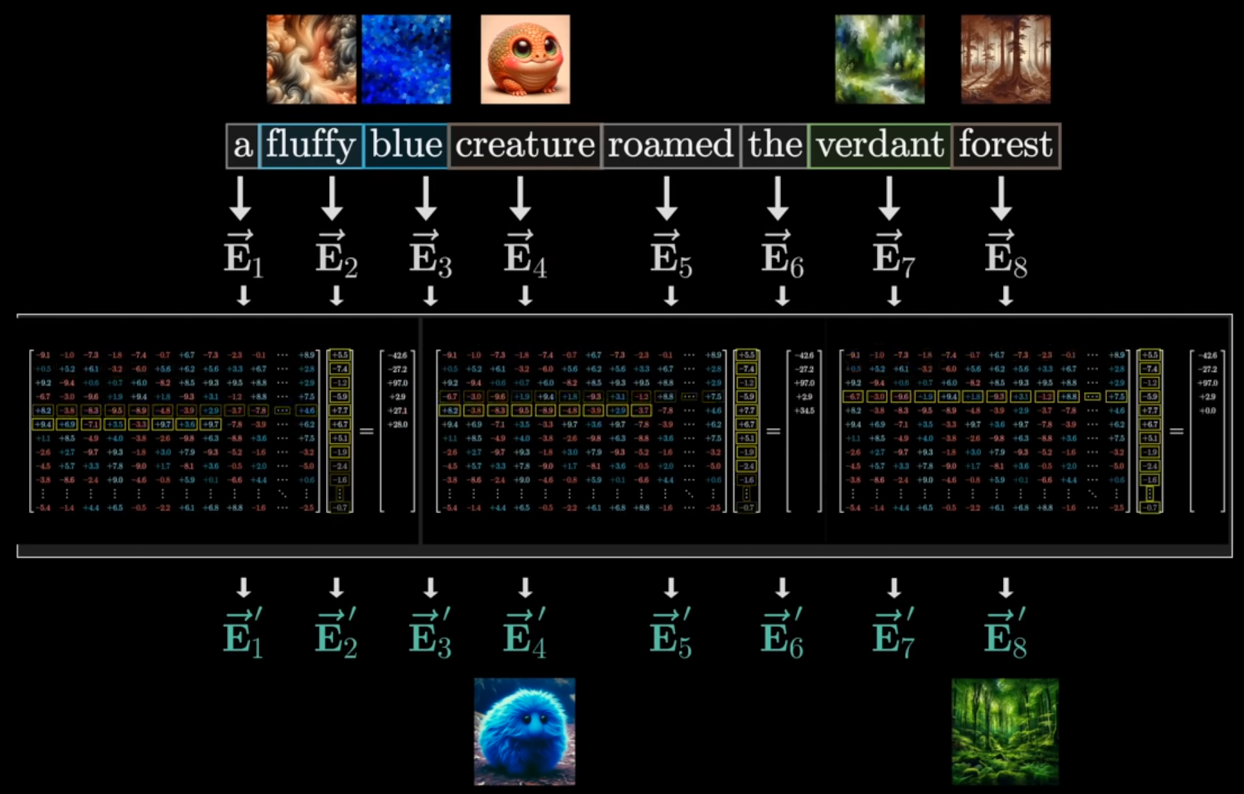

El código para implementar un Attention Head es sorprendentemente simple. Ahora entender a fondo que hace y porqué es tan efectivo es otra cosa.

In [ ]:
class AttentionHead(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C **-.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

### Un ejemplo mínimo de Dot Product Attention
Vamos a ver un ejemplo muy chico las operaciones que haría un attention head y vamos a ver las diferencias entre los diferentes mecanismos de attention.

In [1]:
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
T = 8
C = 5
torch.manual_seed(42)
emb = torch.randn(T, C)

In [2]:
emb

tensor([[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784],
        [-1.2345, -0.0431, -1.6047, -0.7521,  1.6487],
        [-0.3925, -1.4036, -0.7279, -0.5594, -0.7688],
        [ 0.7624,  1.6423, -0.1596, -0.4974,  0.4396],
        [-0.7581,  1.0783,  0.8008,  1.6806,  0.0349],
        [ 0.3211,  1.5736, -0.8455,  1.3123,  0.6872],
        [-1.0892, -0.3553, -1.4181,  0.8963,  0.0499],
        [ 2.2667,  1.1790, -0.4345, -1.3864, -1.2862]])

In [3]:
att = torch.zeros(T, C)
for t in range(T):
    embprev = emb[:t+1]
    att[t] = torch.mean(embprev,0)
att

tensor([[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784],
        [ 0.3462,  0.7221, -0.3520, -1.4288,  1.1636],
        [ 0.1000,  0.0135, -0.4773, -1.1390,  0.5194],
        [ 0.2656,  0.4207, -0.3979, -0.9786,  0.4995],
        [ 0.0608,  0.5522, -0.1581, -0.4468,  0.4066],
        [ 0.1042,  0.7225, -0.2727, -0.1536,  0.4533],
        [-0.0663,  0.5685, -0.4363, -0.0036,  0.3957],
        [ 0.2254,  0.6448, -0.4361, -0.1765,  0.1855]])

In [11]:
lim=8
emb[:lim],torch.mean(emb[:lim],0)

(tensor([[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784],
         [-1.2345, -0.0431, -1.6047, -0.7521,  1.6487],
         [-0.3925, -1.4036, -0.7279, -0.5594, -0.7688],
         [ 0.7624,  1.6423, -0.1596, -0.4974,  0.4396],
         [-0.7581,  1.0783,  0.8008,  1.6806,  0.0349],
         [ 0.3211,  1.5736, -0.8455,  1.3123,  0.6872],
         [-1.0892, -0.3553, -1.4181,  0.8963,  0.0499],
         [ 2.2667,  1.1790, -0.4345, -1.3864, -1.2862]]),
 tensor([ 0.2254,  0.6448, -0.4361, -0.1765,  0.1855]))

In [7]:
(1.9269+ -1.2345)/2

0.34620000000000006

### Haciendo lo mismo pero multiplicando matrices
Se puede hacer lo mismo y ser muy muy MUY eficiente haciendo la misma operación pero multiplicando matrices. La ventaja es que la multiplicación de matrices es una operación masivamente paralela. Ténicamente, el tipo de paralelismo de esta operación es SIMD (Single Instruction Multiple Data), que significa que se hace la misma operación (sumas y multiplicaciones) pero en múltiples datos a la vez. Por lo tanto, se pueden usar placas de video para hacer estas operaciones como si los datos de las matrices fuera pixels, (kind of).

In [18]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a /= a.sum(1, keepdims=True)
b = torch.randint(0,10,(3,2)).float()
c = a@b

In [19]:
print('a')
print(a , '3x3')
print('b')
print(b, '3x2')
print('c')
print(a@b,'3x3 @ 3x2 --> 3x2')

a
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]]) 3x3
b
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]]) 3x2
c
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]]) 3x3 @ 3x2 --> 3x2


In [24]:
wei = torch.tril(torch.ones(T, T))
wei /= wei.sum(1, keepdims=True)

In [30]:
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [29]:
att2 = wei @ emb
att2, att

(tensor([[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784],
         [ 0.3462,  0.7221, -0.3520, -1.4288,  1.1636],
         [ 0.1000,  0.0135, -0.4773, -1.1390,  0.5194],
         [ 0.2656,  0.4207, -0.3979, -0.9786,  0.4995],
         [ 0.0608,  0.5522, -0.1581, -0.4468,  0.4066],
         [ 0.1042,  0.7225, -0.2727, -0.1536,  0.4533],
         [-0.0663,  0.5685, -0.4363, -0.0036,  0.3957],
         [ 0.2254,  0.6448, -0.4361, -0.1765,  0.1855]]),
 tensor([[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784],
         [ 0.3462,  0.7221, -0.3520, -1.4288,  1.1636],
         [ 0.1000,  0.0135, -0.4773, -1.1390,  0.5194],
         [ 0.2656,  0.4207, -0.3979, -0.9786,  0.4995],
         [ 0.0608,  0.5522, -0.1581, -0.4468,  0.4066],
         [ 0.1042,  0.7225, -0.2727, -0.1536,  0.4533],
         [-0.0663,  0.5685, -0.4363, -0.0036,  0.3957],
         [ 0.2254,  0.6448, -0.4361, -0.1765,  0.1855]]))

### Agregando Softmax
Una forma más flexible de construir la matriz `wei` es usando softmax. Enseguida vamos a ver por que esto es mejor...

In [46]:
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros(T, T)
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
att3 = wei @ emb

In [47]:
att, att2, att3

(tensor([[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784],
         [ 0.3462,  0.7221, -0.3520, -1.4288,  1.1636],
         [ 0.1000,  0.0135, -0.4773, -1.1390,  0.5194],
         [ 0.2656,  0.4207, -0.3979, -0.9786,  0.4995],
         [ 0.0608,  0.5522, -0.1581, -0.4468,  0.4066],
         [ 0.1042,  0.7225, -0.2727, -0.1536,  0.4533],
         [-0.0663,  0.5685, -0.4363, -0.0036,  0.3957],
         [ 0.2254,  0.6448, -0.4361, -0.1765,  0.1855]]),
 tensor([[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784],
         [ 0.3462,  0.7221, -0.3520, -1.4288,  1.1636],
         [ 0.1000,  0.0135, -0.4773, -1.1390,  0.5194],
         [ 0.2656,  0.4207, -0.3979, -0.9786,  0.4995],
         [ 0.0608,  0.5522, -0.1581, -0.4468,  0.4066],
         [ 0.1042,  0.7225, -0.2727, -0.1536,  0.4533],
         [-0.0663,  0.5685, -0.4363, -0.0036,  0.3957],
         [ 0.2254,  0.6448, -0.4361, -0.1765,  0.1855]]),
 tensor([[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784],
         [ 0.3462,  0.7221, -0.3520, -1.4288

De esta manera `wei` puede interpretarse como una matriz que representa la afinidad de los tokens entre si. Al comienzo se inicializa en ceros y a medida que avanza el entrenamiento, `wei` aprende que tokens son más interesantes para uno en particular.

### Agregando la dimensión del batch
Para entrenar el mecanismo de attention hace falta una cantidad importante de datos. Por lo tanto no vamos a mandar los ejemplos de a poquito, vamos a mandarlos en batches. Por suerte, todo lo que hemos hecho hasta ahora y el poder de broadcasting de arrays de pytorch nos va a dejar agregar la dimensión de batch relativamente fácil.

Lo interesante aqui es que cada batch se procesa independientemente. Un ejercicio interesante es tratar de imaginarse el grafo de operaciones de `wei@emb`. Este grafo de operaciones todavía puede ser ampliado para incluir el cálculo de una función de pérdida y sobre el cual se puede hacer `.backwards()` para actualizar los pesos de `wei`. 

In [48]:
B = 4
T = 8
C = 5
torch.manual_seed(42)
emb = torch.randn(B, T, C)
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros(T, T)
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
att = wei@emb

In [52]:
# (4, 8, 8) @ (4,8,5) > (4,8,5)
#  (1, 8, 8)
# (4, 8, 5)
emb.shape, wei.shape

(torch.Size([4, 8, 5]), torch.Size([8, 8]))

In [57]:
att[1], emb[1]

(tensor([[-1.5576,  0.9956, -0.8798, -0.6011, -1.2742],
         [ 0.2826, -0.1195, -0.6838, -0.7575, -0.9661],
         [ 0.2144,  0.0956, -0.6186, -0.1079, -0.9154],
         [-0.0232, -0.2791, -0.4549, -0.0968, -0.5177],
         [-0.0381,  0.1456, -0.6008,  0.1993, -0.1251],
         [ 0.1110,  0.4910, -0.4135,  0.2239, -0.1371],
         [-0.0555,  0.6035, -0.3790,  0.2667, -0.1095],
         [ 0.0047,  0.5999, -0.4119, -0.0424, -0.1896]]),
 tensor([[-1.5576,  0.9956, -0.8798, -0.6011, -1.2742],
         [ 2.1228, -1.2347, -0.4879, -0.9138, -0.6581],
         [ 0.0780,  0.5258, -0.4880,  1.1914, -0.8140],
         [-0.7360, -1.4032,  0.0360, -0.0635,  0.6756],
         [-0.0978,  1.8446, -1.1845,  1.3835,  1.4451],
         [ 0.8564,  2.2181,  0.5232,  0.3466, -0.1973],
         [-1.0546,  1.2780, -0.1722,  0.5238,  0.0566],
         [ 0.4263,  0.5750, -0.6417, -2.2064, -0.7508]]))

### El Mecanismo de Attention
El promedio no es una forma interesante de comunicación entre tokens. El mecanismo de attention calcula dos vectores a partir de los embeddings de un token $E_i$. Un vector $Q_i$ es la `query`, indica que es lo que el token con embedding $E_i$ está buscando. El segundo vector es $K_i$, o `key`, y representa de alguna manera lo que el token **es**. La dimensión de estos vectores $Q_i$ y $K_i$ generalmente es menor que la dimensión del embedding. En el mecanismo de Attetion interviene un tercer vector llamado $V_i$ de values. Este vector es la respuesta a como debe modificarse el embedding $E_i$ en el contexto de los demás tokens. Pero hacer esto para un solo token/embedding no tiene sentido. Es necesarion hacerlo para todos los tokens/embeddings del contexto a la vez.

En nuestro ejemplo, si la dimensión del batch es `B`, el tamaño del contexto es `T` y la dimensión de los embeddings es `C`, para calcular $Q_i$ y $K_i$ debemos crear dos matrices de dimensión `(C, head_dimension)` donde `head_dimension` es una variable que hace referencia a la cantidad dimensiones de $Q_i$ y $K_i$ (y consecuentemente, $V_i$). Lo que vamos a hacer entonces en implementar en Python la fórmula del paper ***Attention is all you need***.

$$Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$ 

```python
head_dimension = 2
B = 4
T = 8
C = 5
tril = torch.tril(torch.ones(T,T))  # Esto es un buffer
Wq = torch.randn(C, head_dimension) # (5,2 )
Wk = torch.randn(C, head_dimension)
Wv = torch.randn(C, head_dimension)
emb = torch.randn(B, T, C)
Q = emb @ Wq     # (4, 8,5) @ (5, 2) --> (4, 8, 2)
K = emb @ Wk
wei = Q @ K.T * C ** -.5    # (4, 8, 2) @ (4, 2, 8) --> (4, 8, 8)
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
V = emb @ Wv # (4, 8, 2)
att = wei @ V  #(4, 8, 8) @ (4, 8, 2) --> (4, 8, 2)
```

Usamos producto punto para determinar que tan bien alineados están los vectores $Q_i$ con $K_i$. Recordemos que

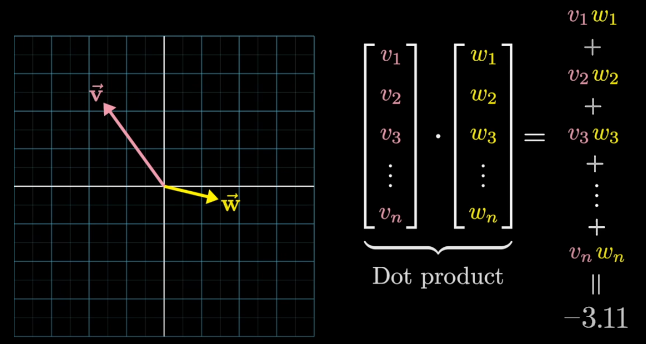
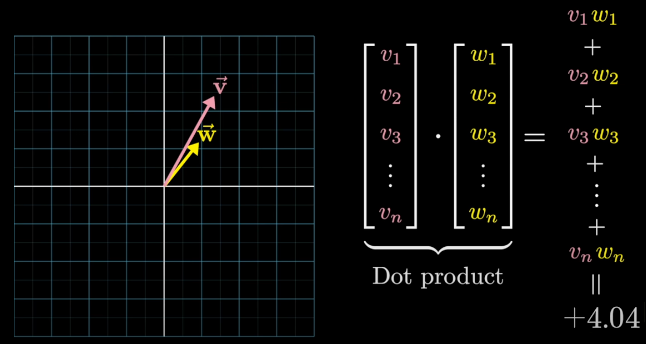

Si $Q_i$ y $K_i$ están muy alineados, son muy afines, entonces el softmax va a devolver valores altos. Si por el contrario, $K_i$ no es importante para $Q_i$, entonces el softmax va a ser cercano a cero.

In [58]:
torch.manual_seed(42)
head_dimension = 2
B = 4
T = 8
C = 5
tril = torch.tril(torch.ones(T,T))  # Esto es un buffer
Wq = torch.randn(C, head_dimension)
Wk = torch.randn(C, head_dimension)
Wv = torch.randn(C, head_dimension)
emb = torch.randn(B, T, C)
Q = emb @ Wq
K = emb @ Wk
wei = Q @ K.transpose(-2, -1) * C ** -.5  # Por esto se llama "scaled" dot product attention
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
V = emb @ Wv
att = wei @ V

In [60]:
att.shape

torch.Size([4, 8, 2])

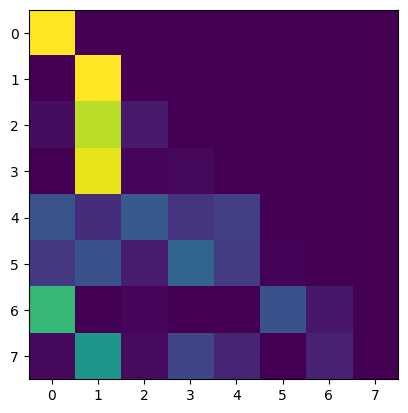

In [62]:
plt.imshow(wei[0])

## Notas importantes
* Attention puede verse como un mecanismo de comunicación entre nodos en un grafo dirigido. En el caso de Masked Self Attention, el grafo tiene un a estructura particular.
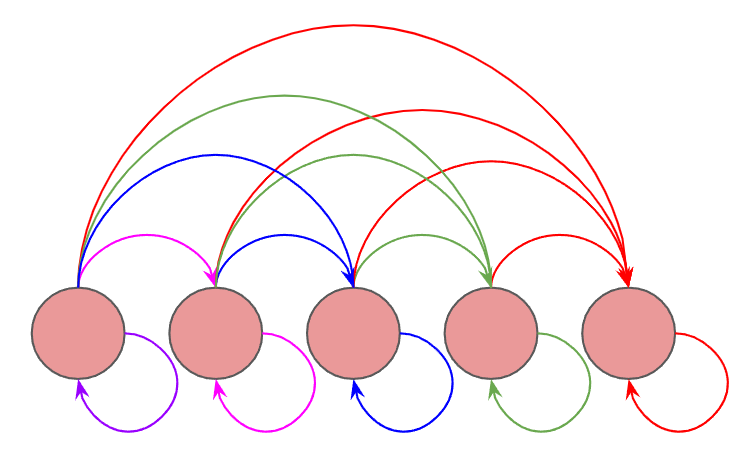

* No hay una noción de espacio como en el caso de las redes convolucionales. Por eso es necesario tener un embedding para el token sino también un embedding para la posición del token (possitional embedding).
* No hay comunicacion entre batches. Los batches se procesan independientemente de los demás. Esto se hace para aprovechar el paralelismo que proveen las GPUs.


* Cross Attention vs Self Attention
* Masked Attention vs Unmasked Attention
* Multi-head Attention vs Single Head Attention
* Encoder block vs Decoder Block
  
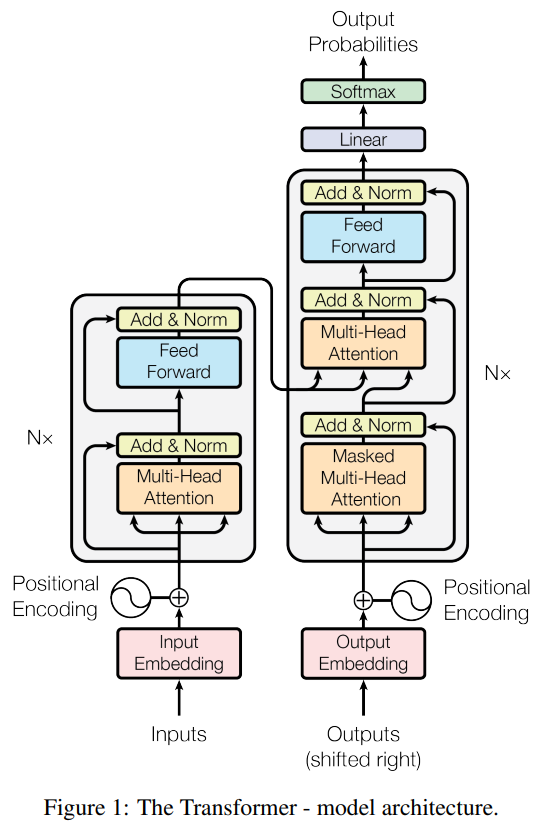

* Scaled Attention. La escala es importante por que, sobre todo durante la inicialización, si `wei` no es difusa, el `softmax(wei)` va a converger a algo de tipo one hot. Es decir, vamos a estar agregando información solamente de un nodo, y la información de los demás nodos va a desaparecer.

In [ ]:
BERT 

### Recursos
* [Attention is all you need paper](https://arxiv.org/abs/1706.03762v1)
* [3Blue1Brown - Neural Networks series](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)
* [LLM Visualization](https://bbycroft.net/llm)
* [Christian Olah blog](https://colah.github.io/)

## Resumen
* El mecanismo de atención como herramienta de trasmisión de información
  * Trasmitiendo información a un token desde el contexto
  * Transformando embeddings
* Scaled dot-product Attention
* Tipos de Attention
  * Self Attention vs Cross Attention
  * Masked vs Unmasked Attention (causal)
  * Single Head vs Multi Head Attention
* Implementación de los diferentes mecanismos de atención

## Que sigue?